# **Benign vs. Malignant Skin Lesion Classifier**

# Setting Up Environment

In [1]:
# Import and configure warnings to ignore minor warnings
from warnings import filterwarnings

# Visualization libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import numerical operations and array handling library
import numpy as np

# Import core PyTorch libraries for neural network construction
import torch
import torch.nn as nn  # Neural network layers and functions
import torch.optim as optim # Optimization algorithms

# Import sklearn's confusion matrix for model evaluation
from sklearn.metrics import confusion_matrix

# Import modules for analysing results
from sklearn.metrics import classification_report, accuracy_score

# Import torchvision for image-based model utilities
from torchvision import models, datasets, transforms # Pre-built models, data handling, and image transformations

# Data loader utilities for batching, shuffling, and splitting data
from torch.utils.data import DataLoader, random_split

# Utilities for mixed precision training to enhance performance
from torch.cuda.amp import autocast, GradScaler

# Learning rate scheduler to improve training efficiency
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Import metric calculation tools specifically for classification
from torchmetrics.classification import BinaryAccuracy

import copy
filterwarnings('ignore') # Ignore warnings that do not signal breakdown

In [2]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

In [3]:
# Sets the device for computation to 'cuda' (GPU) if available, otherwise goes back to 'cpu' (Central Processing Unit). 
# This enables optimal use of hardware by leveraging GPU acceleration when possible.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Cleaning Up Data

In [4]:
# Define image target size after the following transformations - referred to in the resizing line
ImageDimensions = 170

# Training transformer - These random transformations help in augmenting the 
# data by providing varied orientations and perspectives of the same image, 
# thus helping the model generalise better during training by learning to 
# recognise patterns under various transformations - especially useful for DermaTrack
transformer = transforms.Compose([
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True), # Resises to ImageDimensions dimensions with antialias to keep image quality high
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),#Crops from the centre of the image to keep the lesion in the image
    # Rotate and Flip for better training
    transforms.RandomRotation(degrees = 20),# Random rotation +/-20 degrees
    transforms.RandomHorizontalFlip(p = 0.3), # Random horizontal flip occurs 30% of the time
    transforms.RandomVerticalFlip(p = 0.3), # Random vertical flip occurs 30% of the time
    # Convert for model 
    transforms.ToTensor(), #Converts all images to tensors, which is a suitable input for the model
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Normalises the tensors using standard mean and std
])

# Test/Validation transformer - does the same as above without the random flips/rotations
# Randomness is exluded to ensure consistency in evaluation so images are simply formatted
valTransformer = transforms.Compose([
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True),
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
DATA_PATH = '/kaggle/input'
import os
def get_data_distribution(data):
    data_path = data
    class_counts = {}

    for class_label in os.listdir(data_path):
        class_path = os.path.join(data_path, class_label)
        number_of_images = len(os.listdir(class_path))
        class_counts[class_label] = number_of_images

    for class_name, counts in class_counts.items():
        print(f"Class: {class_name}, Number of images: {counts}")
        
    return class_counts
        
class_counts = get_data_distribution(os.path.join(DATA_PATH, 'train'))

Class: Benign, Number of images: 6289
Class: Malignant, Number of images: 5590


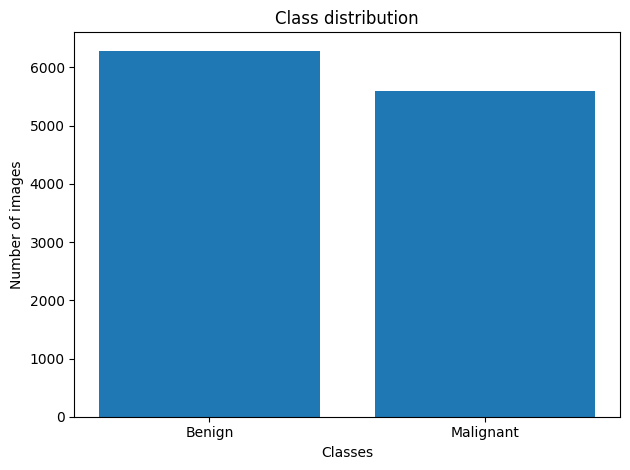

In [6]:
def plot_distribution(class_counts):
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Class distribution')
    plt.tight_layout()
    plt.show()
    
plot_distribution(class_counts)

In [7]:
def visualize_classes(data):
    dict_for_five_item_in_each_class = {}
    for class_label in os.listdir(data):
        class_path = os.path.join(data, class_label)
        items_paths = []
        for idx, item in enumerate(os.listdir(class_path)):
            if idx < 5:
                items_paths.append(os.path.join(class_path, item))
        dict_for_five_item_in_each_class[class_label] = items_paths
    
    return dict_for_five_item_in_each_class

dict_for_five_item_in_each_class = visualize_classes(os.path.join(DATA_PATH, 'train'))

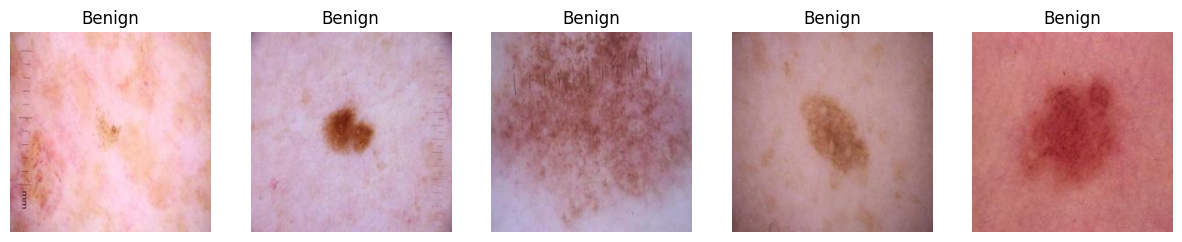

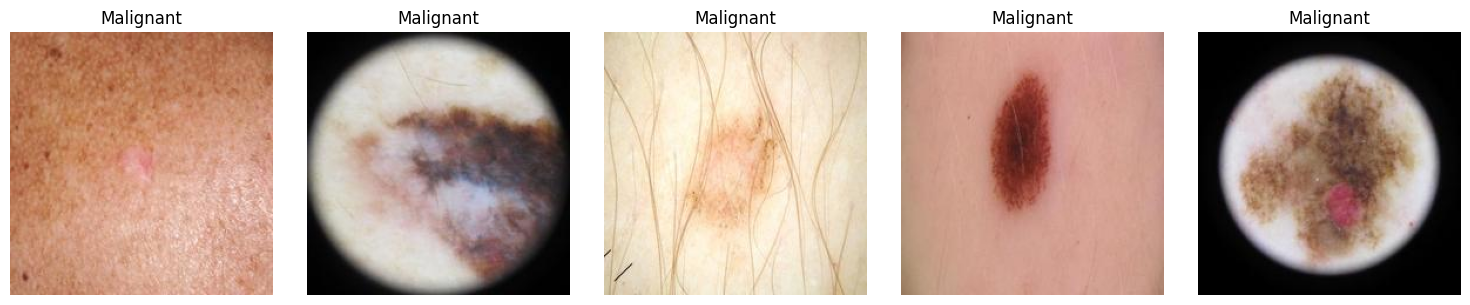

In [8]:
import PIL

def plot_5_images_from_each_class(dict_for_five_item_in_each_class):
    for class_labels, image_paths in dict_for_five_item_in_each_class.items():
        plt.figure(figsize=(15, 3))
        for i, image_path in enumerate(image_paths):
            img = PIL.Image.open(image_path)
            plt.subplot(1, len(image_paths), i + 1)
            plt.imshow(img)
            plt.title(class_labels)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_5_images_from_each_class(dict_for_five_item_in_each_class)

# Splitting and Loading DataSets

In [9]:
# Define the path to the training images directory
trainpath = '/kaggle/input/train'#stored locally on kaggle

# Define the path to the testing images directory
testPath = '/kaggle/input/test'#stored locally on kaggle

# Load the traing datasets from above path and apply the transformations 
# from above block
trainData = datasets.ImageFolder(root = trainpath, transform = transformer)
testData = datasets.ImageFolder(root = testPath, transform = valTransformer)

In [10]:
len(trainData) # Retrieves the total number of images in the trainData dataset, should be in the thousands

11879

In [11]:
# Define the sizes of each split
# total_samples = len(trainData) # Obtains total number of samples
# train_size = int(0.9 * total_samples) # Sets training set to 90% of total
# val_size = total_samples - train_size # Sets validation set to 10% of total

# # Split the dataset randomly into specified sizes
# trainData, valData = torch.utils.data.random_split(trainData, [train_size, val_size])

In [12]:
# Data loaders
batchSize = 16#32 #happy medium verified through testing

# Configure DataLoader for the training dataset
# Shuffling helps prevent the model from learning the order of data, enhancing generalisation
trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)

# Configure DataLoaders for validation and testing datasets
# No shuffling is needed as these loaders are used only for evaluating the model performance consistently

############# commented on 19th May 2024#####################
# valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)
testLoader = DataLoader(testData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [13]:
# # Visualise a dataloader
# train_data, train_label = next(iter(trainLoader)) # Fetches the first batch of data

# # Output the shapes of the data and label tensors to verify their dimensions
# # This helps in understanding the batch size and the data structure being passed into the model
# train_data.shape, train_label.shape

# Setting Up Model

In [14]:
# Using a pre-trained EfficientNetV2L model with default weights
# model = models.efficientnet_b7(weights = 'DEFAULT')

# # Modify the final classifier layer for binary classification
# # Replace the second layer in the classifier module with a new linear layer that outputs 1 feature
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Display the modified classifier to verify changes
# print("Modified classifier:", model.classifier)

In [15]:
# Define the loss function for binary classification. BCEWithLogitsLoss combines a Sigmoid layer 
# and the BCELoss in one single class, which makes it more numerically stable than using a plain Sigmoid 
# followed by a BCELoss as separate operations.
# criterion = nn.BCEWithLogitsLoss()

# Initialise the optimiser with the model parameters and a learning rate of 0.001.
# Adam optimizer is used here because it combines the advantages of two other extensions of stochastic gradient descent.
# Specifically:
# 1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance 
#    on problems with sparse gradients (e.g., natural language and computer vision problems).
# 2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted 
#    based on the average of recent magnitudes of the gradients for the weight (which means it does well on online 
#    and non-stationary problems).
# optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, 
                 min_delta=0,
                 restore_best_weights=True, path="best_model.pth"):
        # Initialise the early stopping mechanism
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        self.path = path # Sets path to save the best model
        self.early_stop = False

    def save_checkpoint(self, model):
        #Save the model's state dictionary
        torch.save(model.state_dict(), self.path)

    def __call__(self, model, val_loss,n,epoch):
        
        self.save_checkpoint(model)
        
        # Chcek if early stopping should be triggered
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                    self.save_checkpoint(model)
                self.early_stop = True
                return True
        return False

In [17]:
# Initialise the EarlyStopping mechanism to monitor validation loss improvements.
# Sets 'patience' to 10 to allow 10 epochs without improvement before stopping.
# Sets 'min_delta' to 0.0 to consider any decrease in loss as improvement.
# early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

# Training Step

In [18]:
# Import tqdm for progress bar visualisation
# The 'autonotebook' submodule automatically chooses the appropriate interface (text or graphical).
from tqdm.autonotebook import tqdm

In [19]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    # Set the model to training mode
    model.train()
    
    # Initilise cumulative loss and accuracy metrics
    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)
    
    # Process each batch using the dataloader
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        # Transfers input and labels to the appropriate device
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        # Forward pass through the model while removing extraneous dimensions from the output
        y_pred = model(X).squeeze()
        # Computes the loss between model predictions and true labels
        loss = loss_fn(y_pred, y)
        # Accumulates the loss values for later averaging
        train_loss += loss.detach().cpu().item()
        
        # Clears previous gradients before backwards pass
        optimizer.zero_grad()
        # Computes gradients of the loss with respect to model parameters
        loss.backward()
        # Adjusts model weights based on computed gradients
        optimizer.step()
        
        # Calculates probabilities from logits for accuracy measurements
        y_proba = torch.sigmoid(y_pred)
        # Updates accuracy metric with current batch's results
        accuracy_train.update(y_proba, y)
        
    #Calculates and returns the average loss and accuracy for the epoch    
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader) # Average loss across all batches
    
    return train_loss, train_accuracy

# Validation Step

In [20]:
def val_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    # Sets the model to evaluation mode
    model.eval()
    
    # Initialises the valdation loss accumulator
    val_loss = 0.
    # Initialises the accuracy metric for validation data, setting the threshold for binary classification
    accuracy_val = BinaryAccuracy(threshold = 0.5).to(device)
    
    # Iterates ove the validation data loader
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        # Transfers input and labels to the appropriate device
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        # Forward pass; compute the model's predictions for the batch
        y_pred = model(X).squeeze() # Squeeze removes dimensions of size 1 from the tensor
        #Computes the loss between the predictions and actual labels
        loss = loss_fn(y_pred, y)
        # Accumulates the loss over all batches
        val_loss += loss.detach().cpu().item()
        
        # Calculates the probabilities from the model's logits
        y_proba = torch.sigmoid(y_pred)
        #Updates the accuracy metric for the batch
        accuracy_val.update(y_proba, y)
    # Finalises the accuracy computation after processing all batches    
    val_accuracy = accuracy_val.compute()
    val_loss = val_loss/len(dataloader) # Average over all batches
    
    return val_loss, val_accuracy

# Training Loop

In [21]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimzier:torch.optim.Optimizer, 
          epochs:int,fold_num):
        # Initialises the lowest recorded validation loss to infinity for tracking the best model
    best_test_loss = float('inf')
    
    # Dictionary to store metrics across epochs
    results = {'train_loss':[], 
               'train_accuracy':[], 
               'val_loss':[], 
               'val_accuracy':[]}
    
    # Loops through each epoch, monitoring training and validation progress with a progress bar
    for epoch in tqdm(range(epochs)):
        # Performs a training step and captures trainign loss and accuracy
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        # Performs a validation step and captures validation loss and accuracy
        val_loss, val_accuracy = val_step(model = model, 
                                             dataloader = val_dataloader, 
                                             loss_fn = loss_fn)
        
        
        # Prints out epoch metrics to monitor progress
        print(f"Epoch: {epoch+1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"val Loss: {val_loss:.4f} | ", 
              f"val Accuracy: {val_accuracy:.4f}")
        
        # Checks if early stopping conditions are met
        early_stopping = EarlyStopping(patience = 2, min_delta = 0.0,path=f"best_model_fold{fold_num}.pth")
        early_stopping(model,val_loss,epoch+1,epochs)
    
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break # If they are it stops
        
        # Saves metrics to the results dictionary for later
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy.detach().cpu().item())
              
    return results   # Returns the collected metrics for all completed epochs

In [22]:
# Will train for 200 epochs
EPOCHS = 10 #200

# Sets a seed for reproducibility of results
SEED = 42
torch.manual_seed(SEED) # Seed the random number generator for the CPU
torch.cuda.manual_seed(SEED) # Seed the random number generator for CUDA

# Checks if cuda is available
# if torch.cuda.is_available():
#     model.cuda()
    # Begins training the model using specified parameters
    
    
# Kfold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
MODEL_RESULTS = {}
for fold, (train_index, val_index) in enumerate(kf.split(trainLoader.dataset)):
#     print(f'Fold {fold + 1}/{num_folds}')
    print('=' * 20, 'Fold', fold, '=' * 20)  
    # Obtain the data for the current fold
    train_data_fold = torch.utils.data.Subset(trainLoader.dataset, train_index)
    val_data_fold = torch.utils.data.Subset(trainLoader.dataset, val_index)

    # Create data loaders for the current fold
    train_loader_fold = DataLoader(train_data_fold, batch_size=batchSize, shuffle=True, num_workers = 4)
    val_loader_fold = DataLoader(val_data_fold, batch_size=batchSize, shuffle=False, num_workers = 4)
    
    ############ Model ####################
    model = models.efficientnet_b7(weights = 'DEFAULT')
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    
    if torch.cuda.is_available():
        model.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    #######################################
    
    MODEL_RESULTS[fold] = train(model, train_loader_fold, val_loader_fold, criterion, optimizer, EPOCHS,fold_num=fold)

# MODEL_RESULTS = train(model, trainLoader, valLoader, criterion, optimizer, EPOCHS)

==================== Fold 0 ====================


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 150MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3689 |  Train Accuracy: 0.8454 |  val Loss: 0.7914 |  val Accuracy: 0.8535


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2939 |  Train Accuracy: 0.8792 |  val Loss: 0.2736 |  val Accuracy: 0.8889


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2667 |  Train Accuracy: 0.8913 |  val Loss: 0.3626 |  val Accuracy: 0.8451


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2503 |  Train Accuracy: 0.8979 |  val Loss: 0.2958 |  val Accuracy: 0.8868


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2385 |  Train Accuracy: 0.8994 |  val Loss: 0.2628 |  val Accuracy: 0.8864


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2282 |  Train Accuracy: 0.9098 |  val Loss: 0.2943 |  val Accuracy: 0.8893


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2142 |  Train Accuracy: 0.9119 |  val Loss: 0.2774 |  val Accuracy: 0.8801


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.1983 |  Train Accuracy: 0.9199 |  val Loss: 0.2648 |  val Accuracy: 0.8859


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.1984 |  Train Accuracy: 0.9199 |  val Loss: 0.2359 |  val Accuracy: 0.9024


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.1878 |  Train Accuracy: 0.9232 |  val Loss: 0.2361 |  val Accuracy: 0.9070
==================== Fold 1 ====================


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3578 |  Train Accuracy: 0.8444 |  val Loss: 0.3011 |  val Accuracy: 0.8822


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2994 |  Train Accuracy: 0.8716 |  val Loss: 0.2399 |  val Accuracy: 0.8986


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2672 |  Train Accuracy: 0.8871 |  val Loss: 0.2390 |  val Accuracy: 0.9028


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2686 |  Train Accuracy: 0.8878 |  val Loss: 0.2512 |  val Accuracy: 0.9015


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2475 |  Train Accuracy: 0.8979 |  val Loss: 0.2301 |  val Accuracy: 0.8986


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2296 |  Train Accuracy: 0.9058 |  val Loss: 0.2218 |  val Accuracy: 0.9066


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2215 |  Train Accuracy: 0.9080 |  val Loss: 0.2236 |  val Accuracy: 0.9162


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2179 |  Train Accuracy: 0.9097 |  val Loss: 0.2557 |  val Accuracy: 0.8872


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2004 |  Train Accuracy: 0.9194 |  val Loss: 0.2228 |  val Accuracy: 0.9036


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.1958 |  Train Accuracy: 0.9194 |  val Loss: 0.2215 |  val Accuracy: 0.9116
==================== Fold 2 ====================


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3599 |  Train Accuracy: 0.8411 |  val Loss: 0.3173 |  val Accuracy: 0.8763


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2877 |  Train Accuracy: 0.8800 |  val Loss: 0.2680 |  val Accuracy: 0.9007


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2677 |  Train Accuracy: 0.8905 |  val Loss: 0.2266 |  val Accuracy: 0.9082


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2561 |  Train Accuracy: 0.8953 |  val Loss: 0.2134 |  val Accuracy: 0.9158


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2352 |  Train Accuracy: 0.9001 |  val Loss: 0.2721 |  val Accuracy: 0.9028


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2307 |  Train Accuracy: 0.9072 |  val Loss: 0.2414 |  val Accuracy: 0.9099


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2170 |  Train Accuracy: 0.9112 |  val Loss: 0.2371 |  val Accuracy: 0.9091


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2203 |  Train Accuracy: 0.9093 |  val Loss: 0.2138 |  val Accuracy: 0.9120


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2083 |  Train Accuracy: 0.9183 |  val Loss: 0.2246 |  val Accuracy: 0.9040


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.1969 |  Train Accuracy: 0.9192 |  val Loss: 0.2180 |  val Accuracy: 0.9162
==================== Fold 3 ====================


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3606 |  Train Accuracy: 0.8484 |  val Loss: 0.3322 |  val Accuracy: 0.8805


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2949 |  Train Accuracy: 0.8815 |  val Loss: 0.2372 |  val Accuracy: 0.9011


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2648 |  Train Accuracy: 0.8943 |  val Loss: 0.2392 |  val Accuracy: 0.8960


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2561 |  Train Accuracy: 0.8947 |  val Loss: 0.2575 |  val Accuracy: 0.8977


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2368 |  Train Accuracy: 0.9031 |  val Loss: 0.2734 |  val Accuracy: 0.8939


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2330 |  Train Accuracy: 0.8999 |  val Loss: 0.2321 |  val Accuracy: 0.9003


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2156 |  Train Accuracy: 0.9149 |  val Loss: 0.2079 |  val Accuracy: 0.9162


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2111 |  Train Accuracy: 0.9137 |  val Loss: 0.6130 |  val Accuracy: 0.8607


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2150 |  Train Accuracy: 0.9141 |  val Loss: 0.2603 |  val Accuracy: 0.8939


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2031 |  Train Accuracy: 0.9209 |  val Loss: 1.5896 |  val Accuracy: 0.8611
==================== Fold 4 ====================


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3614 |  Train Accuracy: 0.8466 |  val Loss: 0.3000 |  val Accuracy: 0.8884


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.2968 |  Train Accuracy: 0.8784 |  val Loss: 0.2872 |  val Accuracy: 0.8762


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2877 |  Train Accuracy: 0.8840 |  val Loss: 0.2458 |  val Accuracy: 0.8931


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2572 |  Train Accuracy: 0.8940 |  val Loss: 0.2376 |  val Accuracy: 0.8985


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2521 |  Train Accuracy: 0.9001 |  val Loss: 0.2327 |  val Accuracy: 0.9011


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2405 |  Train Accuracy: 0.9019 |  val Loss: 0.2404 |  val Accuracy: 0.9011


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2255 |  Train Accuracy: 0.9067 |  val Loss: 0.2429 |  val Accuracy: 0.8981


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2195 |  Train Accuracy: 0.9121 |  val Loss: 0.2567 |  val Accuracy: 0.9099


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2149 |  Train Accuracy: 0.9118 |  val Loss: 0.2220 |  val Accuracy: 0.9061


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2074 |  Train Accuracy: 0.9161 |  val Loss: 0.2191 |  val Accuracy: 0.9175


# Assessing Results

In [23]:
SavedModels = [os.path.join("/kaggle/working",i) for i in os.listdir('/kaggle/working') if i.endswith('.pth')]
SavedModels

['/kaggle/working/best_model_fold0.pth',
 '/kaggle/working/best_model_fold3.pth',
 '/kaggle/working/best_model_fold2.pth',
 '/kaggle/working/best_model_fold4.pth',
 '/kaggle/working/best_model_fold1.pth']

In [24]:
SavedModels = sorted(SavedModels,key=lambda x:x.split('.')[0][-1])
SavedModels

['/kaggle/working/best_model_fold0.pth',
 '/kaggle/working/best_model_fold1.pth',
 '/kaggle/working/best_model_fold2.pth',
 '/kaggle/working/best_model_fold3.pth',
 '/kaggle/working/best_model_fold4.pth']

In [25]:
device

'cuda'

===============Fold-0 Model-> /kaggle/working/best_model_fold0.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      1000
         1.0       0.94      0.93      0.93      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.93      2000
weighted avg       0.94      0.94      0.93      2000

Accuracy 0.935


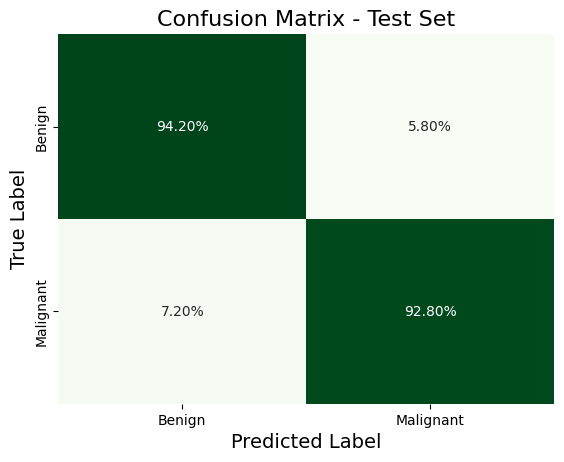

===============Fold-1 Model-> /kaggle/working/best_model_fold1.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      1000
         1.0       0.97      0.86      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

Accuracy 0.9145


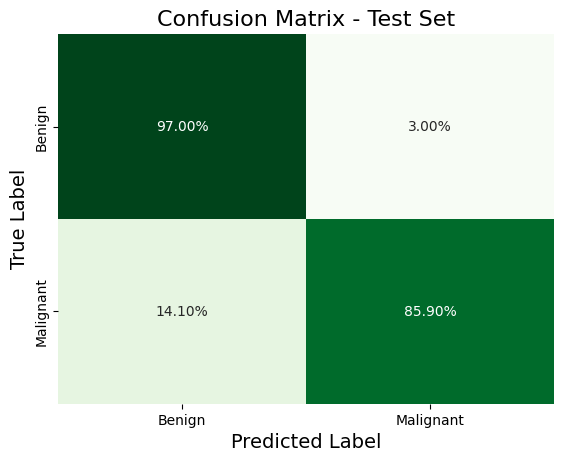

===============Fold-2 Model-> /kaggle/working/best_model_fold2.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      1000
         1.0       0.96      0.87      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy 0.9205


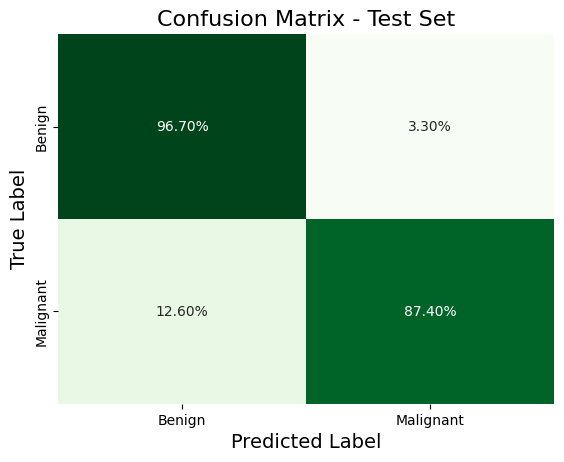

===============Fold-3 Model-> /kaggle/working/best_model_fold3.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.80      0.95      0.87      1000
         1.0       0.94      0.76      0.84      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000

Accuracy 0.8585


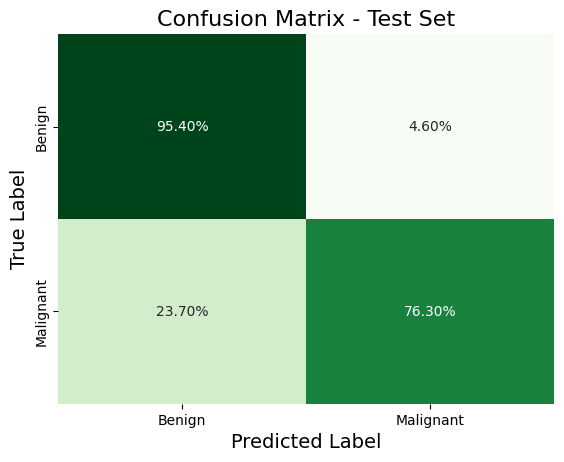

===============Fold-4 Model-> /kaggle/working/best_model_fold4.pth==================
Classification report               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      1000
         1.0       0.94      0.92      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy 0.926


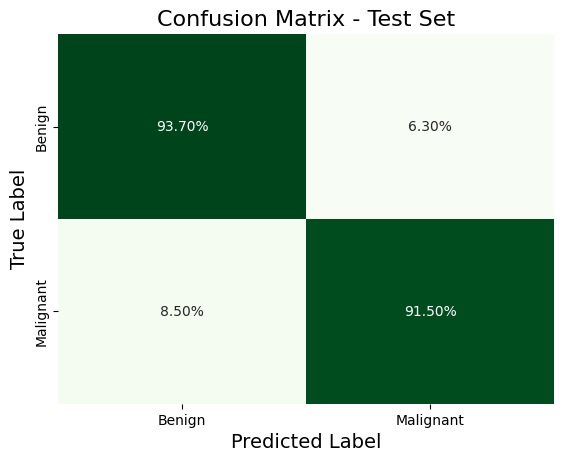

In [26]:
model1 = models.efficientnet_b7(weights = 'DEFAULT')
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 1)
for fold_id, saved_model in enumerate(SavedModels):
    print(f'===============Fold-{fold_id} Model-> {saved_model}==================')
    model1.load_state_dict(torch.load(saved_model)) # map_location=torch.device('cuda') 

    model1.eval() # Switches the model to evaluation mode
    model1 = model1.to(device)
    # initialises lists to store labels and predictions
    allLabels = []
    allPreds = []
    

    # Disables gradient calculations for performance
    with torch.no_grad():
        # Iterates over batches of data in the test dataset
        for inputs, labels in testLoader:
            # Moves the inputs and labels to the configured device
            inputs, labels = inputs.to(device), labels.to(device)
            # Ensures labels are the corerct shape and type for calculation
            labels = labels.unsqueeze(1).float()

            # Generates model outputs for the current batch
            outputs = model1(inputs)
            # Applies a sigmoid activation to convert logits to probabilities andthreshold at 0.5 to obtain binary predictions
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            # Stores and labels predictions, converting tensors to numpy arrays
            allLabels.extend(labels.cpu().numpy())
            allPreds.extend(predictions.cpu().numpy())

    # Converts lists of labels and predicitions into numpy arrays for skylearn        
    allLabels = np.array(allLabels)
    allPreds = np.array(allPreds)

    # Prints classification metrics to evaluate the model
    print('Classification report', classification_report(allLabels,allPreds))
    print('Accuracy', accuracy_score(allLabels,allPreds))

    # Calculates and normalises a confusion matrix
    matrix = confusion_matrix(allLabels, allPreds)
    cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plots the normalised matrix and formats it using seabron
    sns.heatmap(cm_normalized, annot = True, fmt = '.2%', cmap = 'Greens', xticklabels = testData.classes, yticklabels = testData.classes, cbar = False)
    plt.title('Confusion Matrix - Test Set', fontsize = 16)
    plt.xlabel('Predicted Label', fontsize = 14)
    plt.ylabel('True Label', fontsize = 14)
    plt.show()

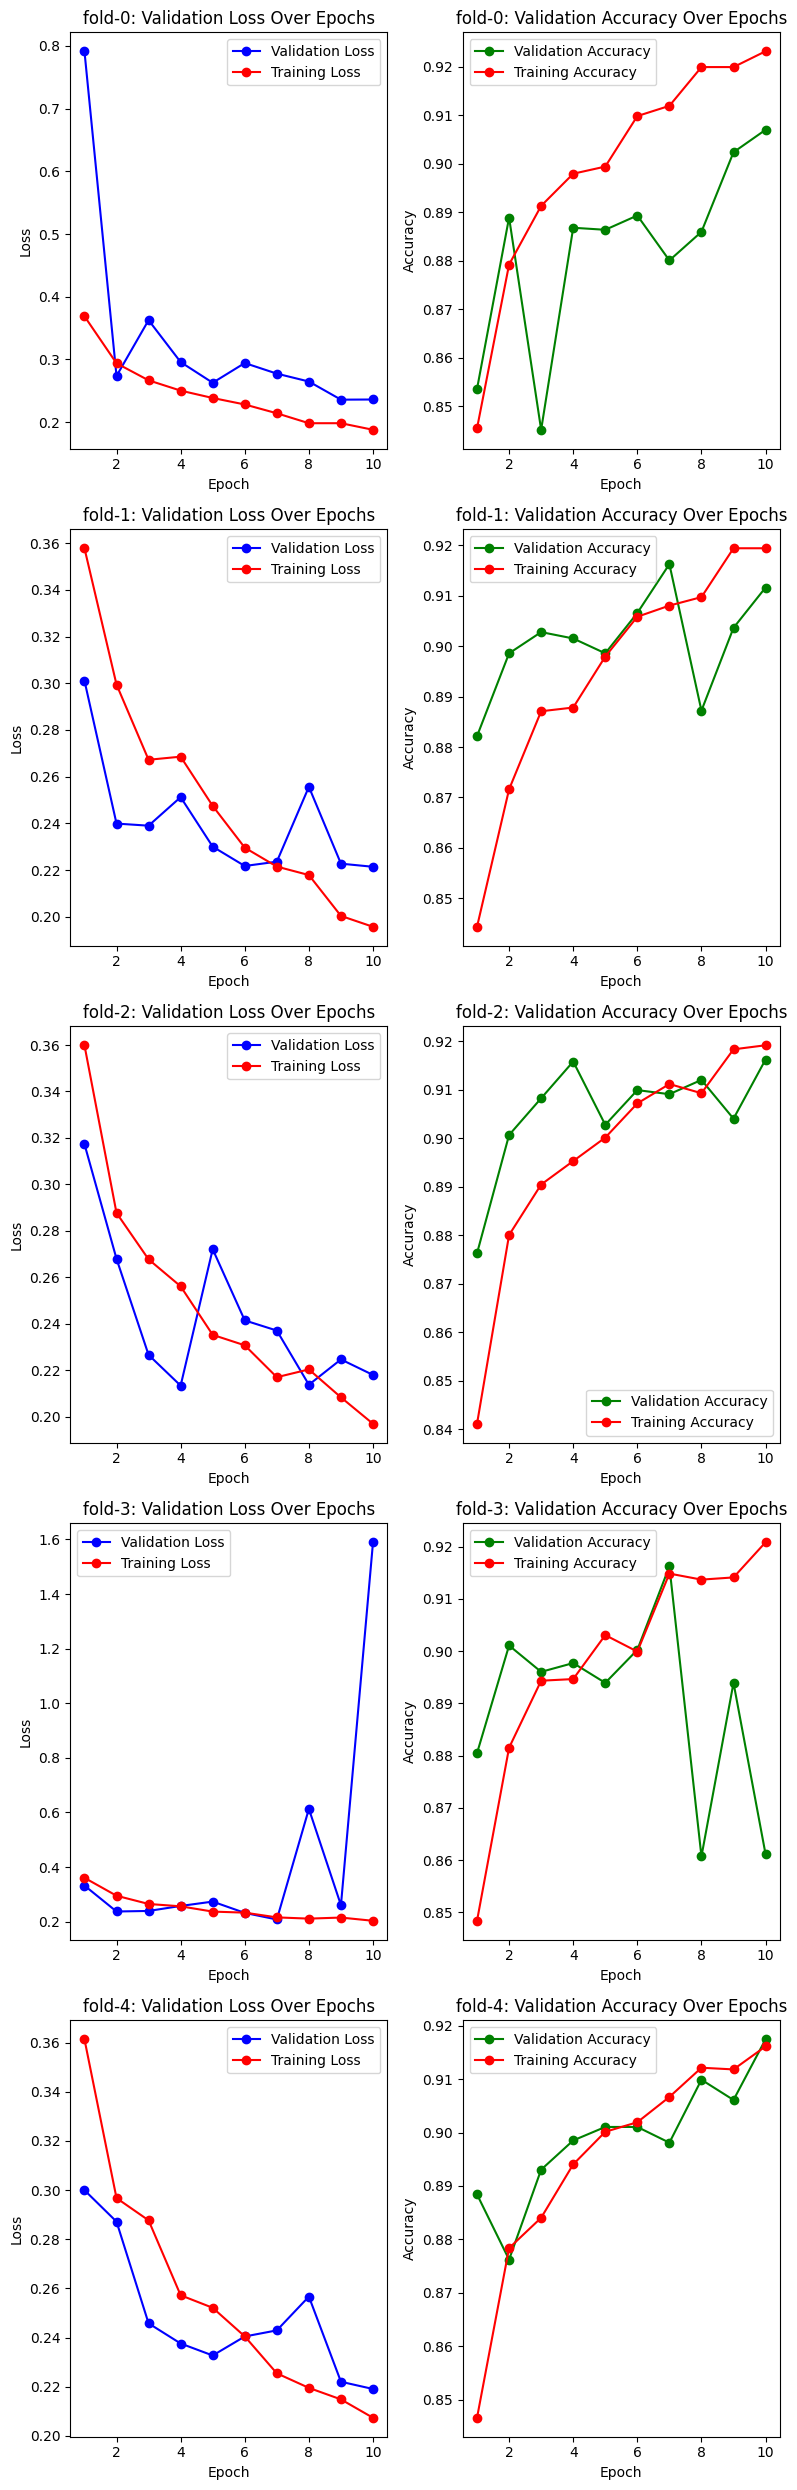

In [27]:
import matplotlib.pyplot as plt

# Assuming you have extracted validation loss and accuracy for each model from MODEL_RESULTS
num_models = 5  # Number of models in MODEL_RESULTS

# Plot validation loss and accuracy for each model using subplots
plt.figure(figsize=(8, 5 * num_models))

for i in range(num_models):
    model_name = i
    val_loss = MODEL_RESULTS[model_name]['val_loss']
    val_accuracy = MODEL_RESULTS[model_name]['val_accuracy']
    
    train_loss = MODEL_RESULTS[model_name]['train_loss']
    train_accuracy = MODEL_RESULTS[model_name]['train_accuracy']
    
    epochs = range(1, len(val_loss) + 1)

    # Subplot for validation loss
    plt.subplot(num_models, 2, 2*i + 1)  # num_models rows, 2 columns, 1st subplot for current model
    plt.plot(epochs, val_loss, 'bo-', label='Validation Loss')
    plt.plot(epochs, train_loss, 'ro-', label='Training Loss')
    plt.title(f'fold-{model_name}: Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot for validation accuracy
    plt.subplot(num_models, 2, 2*i + 2)  # num_models rows, 2 columns, 2nd subplot for current model
    plt.plot(epochs, val_accuracy, 'go-', label='Validation Accuracy')
    plt.plot(epochs, train_accuracy, 'ro-', label='Training Accuracy')
    plt.title(f'fold-{model_name}: Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Prediction Example

In [28]:
model1 = models.efficientnet_b7(weights = 'DEFAULT')
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 1)
model1.load_state_dict(torch.load('/kaggle/working/best_model_fold4.pth',map_location=torch.device('cpu'))) 

from torchvision import transforms
from PIL import Image

image_path = "/kaggle/input/test/Benign/6299.jpg"

In [29]:
inputs.shape

torch.Size([16, 3, 170, 170])

In [30]:
# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (ImageDimensions, ImageDimensions), antialias = True),
    transforms.CenterCrop(size = (ImageDimensions, ImageDimensions)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [31]:
image = Image.open(image_path).convert("RGB")
image = valTransformer(image)

# Reshape the image to add batch dimension
image = image.unsqueeze(0) 

In [32]:
image.shape

torch.Size([1, 3, 170, 170])

In [33]:
testData.class_to_idx

{'Benign': 0, 'Malignant': 1}

In [34]:
target = ['Benign','Malignant']
with torch.no_grad():
    model1.eval()
    inputs = image.to('cpu')
    outputs = model1(inputs)
    predictions = (torch.sigmoid(outputs) > 0.5).float()
    print(target[int(predictions.item())])

Malignant
